# <center> Прогноз оттока клиентов </center>
___
___

## <center> Учебный проект по ML </center>
___
___

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных   

Признаки   

- `RowNumber` — индекс строки в данных;   
- `CustomerId` — уникальный идентификатор клиента;   
- `Surname` — фамилия;   
- `CreditScore` — кредитный рейтинг;   
- `Geography` — страна проживания;   
- `Gender` — пол;   
- `Age` — возраст;   
- `Tenure` — количество недвижимости у клиента;   
- `Balance` — баланс на счёте;   
- `NumOfProducts` — количество продуктов банка, используемых клиентом;   
- `HasCrCard` — наличие кредитной карты;   
- `IsActiveMember` — активность клиента;   
- `EstimatedSalary` — предполагаемая зарплата.   
   
Целевой признак   
- `Exited` — факт ухода клиента.   

## <center> Состав работы </center>   <a id = 'back'></a>

[1. Подготовка данных](#1)
    
   - [1.1. Изучение данных](#1.1)   
   - [1.2. Изменение названий колонок](#1.2)   
   - [1.3. Преобразование категориальных признаков в численные](#1.3)   
   - [1.4. Заполнение пропусков](#1.4)
   - [1.5. Приведение типов данных](#1.5)
   - [1.6. Разбиение на выборки](#1.6)
    
[2. Исследование задачи](#2)   
   
   - [2.1. Оценка дисбаланса классов](#2.1)
   - [2.2. Обучение моделей](#2.2)
   - [2.3. Оценка качества моделей](#2.3)
   - [2.4. ROC-кривая и AUC-ROC-score](#2.4)
   - [2.5. Выводы](#2.5)
   
[3. Борьба с дисбалансом](#3)   
   
   - [3.1. Взвешивание классов](#3.1)
   - [3.2. Upsampling](#3.2)
   - [3.3. Downsampling](#3.3)
   - [3.4. Выводы](#3.4)
   
[4. Тестирование модели](#4)   
[5. Выводы](#5)   

# <center> Ход работы </center>

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, \
                            precision_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

<a id = '1'></a>
## 1. Подготовка данных
___

<a id = '1.1'></a>
Прочитаем и исследуем данные.

In [2]:
churn_data = pd.read_csv('/datasets/Churn.csv')
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
churn_data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Имеем:   
 - пропуски в стобце `Tenure` (количество недвижимости у клиента). Возможно часть клиентов самостоятельно отказывались от предоставления этой информации, но есть ещё шанс связи наличия недвижимости с фактом ухода, например в связи с тяжелым материальным положением клиент продал всё и ушел из банка, либо переехал в место, где нет филиалов "Бета-Банк". Проверим далее.   
 - большинство типов данных выглядят логичными для того, что обозначается этими данными, однако некоторые типы данных логичнее заменить на потребляющие меньше памяти (т.е. int64 на uint8) например в колонке `IsActiveMember`, в которой для обозначения используются только '0' и '1'.     
 - лишним кажется столбец с фамилиями: у нас уже есть уникальный идентификатор клиента (`CustomerId`), так что не возникнет путанницы с идентификацией, а сама по себе фамилия вряд ли влияет на желание клиента уйти из банка.   
 - лишним кажется столбец с индексом строки в данных: у нас в DataFrame-е и так есть столбец с индексами, зачем нам их дубликат?   
 - к столбцам `Geography` и `Gender` необходимо будет применить технику *One-Hot Encoding*.

In [4]:
display(churn_data.loc[churn_data['Tenure'].isna()]['Exited'].value_counts())

0    726
1    183
Name: Exited, dtype: int64

Что ж, высказанное выше предположение о том, что пропуск в поле наличия недвижимости может служить индикатором того, что клиент покинет банк не подтвердилось. Проверим возразст людей в этих строках с пропусками.

In [5]:
display(churn_data.loc[churn_data['Tenure'].isna()]['Age'].value_counts().sort_index())

18     2
19     1
20     3
21     5
22     4
23     7
24     7
25    12
26    18
27    14
28    26
29    35
30    31
31    45
32    44
33    39
34    35
35    43
36    55
37    43
38    53
39    36
40    49
41    28
42    24
43    32
44    24
45    22
46    13
47    14
48    12
49    14
50    14
51     8
52    10
53     8
54     9
55    14
56     8
57     2
58     4
59     6
60     5
61     4
62     4
63     4
64     2
65     2
66     2
67     1
68     2
70     1
71     2
72     1
74     2
75     2
78     1
92     1
Name: Age, dtype: int64

И эта информация не внесла ясности. Было предположение что в данной подборке окажутся люди приблизительно от 18 до 25 лет, которые уже могут быть клиентами банка, но врядли уже владуют недвижимостью. Однако возраст рассматриваемых клиентов довольно разнообразен, причем, как мы видим, как раз большинство клиентов возраста 25+. Проверим есть ли в данных о наличии недвижимости нулевые значения.

In [6]:
print(churn_data.loc[churn_data['Tenure'] == 0]['Tenure'].count())

382


Выясняется что всё же отсутствии недвижимости обозначается нулем а не пропущенным значением. Что ж, просто так заменить на 0 нет предпосылок, как и брать среднее или медианное значение. При этом отсутствующих данных чуть больше 9%. Казалось бы можно попробовать и удалить строки с отсутствующими данными, но:   
1. даже 9% отсутствующих данных многовато, для простого удаления строк;   
2. для других задач отсутствующих данных может быть много больше, а на данный момент ни одна из известных нам моделей не работает с NaN.   
   
Пора учиться работать с ними средствами <a href = "https://scikit-learn.org/stable/modules/impute.html#impute">`scikit-learn`</a>   
Сделаем это чуть ниже, после обработки данных.

P.s.: кстати, как вариант интересен способ: данную колонку представить целевым признаком (по крайней мере пока их у нас 9%), из всех строк с отсутствующим значением сделать тестовую выборку, оставшиеся данные разбить на обучающую и валидационную, обучить, добиться хороших метрик, предсказать по тестовой и предсказанные значения вернуть в исходный датасет...🤔

In [7]:
display(churn_data.duplicated().sum())

0

Дублированных данных нет, хорошо.

In [8]:
display(churn_data.columns)

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

<a id = '1.2'></a>
Заменим названия колонок.

In [9]:
columns_new_names = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_credit_card', 'is_active_member', 'estimated_salary', 'exited']
churn_data.set_axis(columns_new_names, axis = 'columns', inplace = 'True')

In [10]:
churn_data.drop(['row_number', 'surname'], axis = 1, inplace = True)

<a id = '1.3'></a>
Теперь необходимо применить технику прямого кодирования к колонкам `Geography` и `Gender`, при этом, чтобы не попасть в дамми-ловушку, добавим аргумент **drop_first**.

In [11]:
churn_data_ohe = pd.get_dummies(churn_data, drop_first = True)


In [12]:
display(churn_data_ohe.head())

,customer_id,credit_score,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


<a id = '1.4'></a>
Заполняем пропуски с помощью `IterativeImputer`.

In [13]:
imp = IterativeImputer(random_state = 1, n_nearest_features = 10)
churn_data_transformed = imp.fit_transform(churn_data_ohe)

In [14]:
imputed_churn_data = pd.DataFrame(data = churn_data_transformed, columns = churn_data_ohe.columns)

In [15]:
imputed_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
customer_id          10000 non-null float64
credit_score         10000 non-null float64
age                  10000 non-null float64
tenure               10000 non-null float64
balance              10000 non-null float64
num_of_products      10000 non-null float64
has_credit_card      10000 non-null float64
is_active_member     10000 non-null float64
estimated_salary     10000 non-null float64
exited               10000 non-null float64
geography_Germany    10000 non-null float64
geography_Spain      10000 non-null float64
gender_Male          10000 non-null float64
dtypes: float64(13)
memory usage: 1015.8 KB


In [16]:
display(imputed_churn_data.sample(10))

,customer_id,credit_score,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
859,15809087.0,598.0,64.0,1.000000,0.00,2.0,1.0,0.0,195635.30,1.0,0.0,0.0,1.0
7508,15580366.0,566.0,54.0,4.000000,118614.60,2.0,1.0,1.0,172601.62,0.0,1.0,0.0,1.0
7450,15679801.0,712.0,39.0,5.000000,163097.55,2.0,1.0,1.0,23702.42,0.0,0.0,1.0,0.0
3183,15734161.0,636.0,43.0,4.957114,0.00,2.0,1.0,0.0,43128.95,0.0,0.0,0.0,1.0
6094,15575623.0,589.0,31.0,10.000000,110635.32,1.0,1.0,0.0,148218.86,0.0,0.0,0.0,0.0
5039,15775490.0,660.0,38.0,5.000000,110570.78,2.0,1.0,0.0,195906.59,0.0,0.0,0.0,0.0
7191,15567839.0,501.0,42.0,9.000000,114631.23,1.0,0.0,1.0,91429.74,0.0,0.0,0.0,1.0
6531,15675231.0,518.0,45.0,8.000000,0.00,2.0,1.0,1.0,36193.07,0.0,0.0,0.0,0.0
6930,15680685.0,751.0,30.0,3.000000,165257.20,1.0,0.0,0.0,134822.05,0.0,0.0,0.0,1.0
1336,15682563.0,618.0,38.0,5.000000,126473.99,1.0,1.0,0.0,91972.49,0.0,0.0,1.0,1.0


<a id = '1.5'></a>
Что ж, заполнение пропущенных значений выполнено. Теперь приведем всё к более логичным типам данным.

In [17]:
columns_to_uint8 = ['age', 'tenure', 'num_of_products', 'has_credit_card', 'is_active_member', 'exited', 'geography_Germany', 'geography_Spain', 'gender_Male']
for column in columns_to_uint8:
    imputed_churn_data[column] = imputed_churn_data[column].astype(np.uint8)
    
imputed_churn_data['customer_id'] = imputed_churn_data['customer_id'].astype('int')
imputed_churn_data['credit_score'] = imputed_churn_data['credit_score'].astype('int')

In [18]:
imputed_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
customer_id          10000 non-null int64
credit_score         10000 non-null int64
age                  10000 non-null uint8
tenure               10000 non-null uint8
balance              10000 non-null float64
num_of_products      10000 non-null uint8
has_credit_card      10000 non-null uint8
is_active_member     10000 non-null uint8
estimated_salary     10000 non-null float64
exited               10000 non-null uint8
geography_Germany    10000 non-null uint8
geography_Spain      10000 non-null uint8
gender_Male          10000 non-null uint8
dtypes: float64(2), int64(2), uint8(9)
memory usage: 400.5 KB


<a id = '1.6'></a>
Преобразование типов выполнено успешно.   
Разобьём генеральную совокупность на обучающую, валидационную и тестовую выборки.

In [19]:
churn_train, churn_interim = train_test_split(imputed_churn_data, test_size = 0.4, random_state = 1)

Так как *'test_train_split'* разделяет исходные данные на две выборки, а нам нужны три в соотношении 3:1:1 - мы сначала разделили генеральную совокупность на выборки с соотношением 3:2. 60% оставляем на обучающую выборку в переменной `churn_train`. Оставшиеся 40% записываем во временную переменную `churn_interium`.

In [20]:
churn_valid, churn_test = train_test_split(churn_interim, test_size = 0.5, random_state = 1)

Теперь разделили 40% генеральной совокупности на валидационную и тестовую выборки в соотношении 1:1 (таким образом получим для двух выборок по 20% от генеральной совокупности). Запишем результаты в переменные `churn_valid` и `churn_test`.

In [21]:
print('Размер обучающей выборки: {} \nРазмер валидационной выборки: {} \nРазмер тестовой выборки: {}' 
      .format(len(churn_train), len(churn_valid), len(churn_test)))

Размер обучающей выборки: 6000 
Размер валидационной выборки: 2000 
Размер тестовой выборки: 2000


In [22]:
del churn_interim

Проверили как разбились выборки и удалили временную переменную `churn_interim`, чтобы не валялась в памяти. Больше она нам не нужна. Теперь полученные выборки разделяем на признаки и цели.

In [23]:
churn_train_features = churn_train.drop(['exited'], axis = 1)
churn_train_target = churn_train['exited']

In [24]:
churn_valid_features = churn_valid.drop(['exited'], axis = 1)
churn_valid_target = churn_valid['exited']

In [25]:
churn_test_features = churn_test.drop(['exited'], axis = 1)
churn_test_target = churn_test['exited']

Данные подготовлены к дальнейшей работе.

___
[*К содержанию*](#back)

## 2. Исследование задачи
___

<a id = '2.1'></a>
Оценим дисбаланс классов.

In [26]:
frequencies_data = pd.DataFrame(data = [churn_train_target.value_counts(normalize = True), \
                                        churn_valid_target.value_counts(normalize = True), \
                                        churn_test_target.value_counts(normalize = True)], \
                                        index = ['train','valid','test'])

In [27]:
frequencies_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, train to test
Data columns (total 2 columns):
0    3 non-null float64
1    3 non-null float64
dtypes: float64(2)
memory usage: 72.0+ bytes


Text(0, 0.5, 'values count (relative unit)')

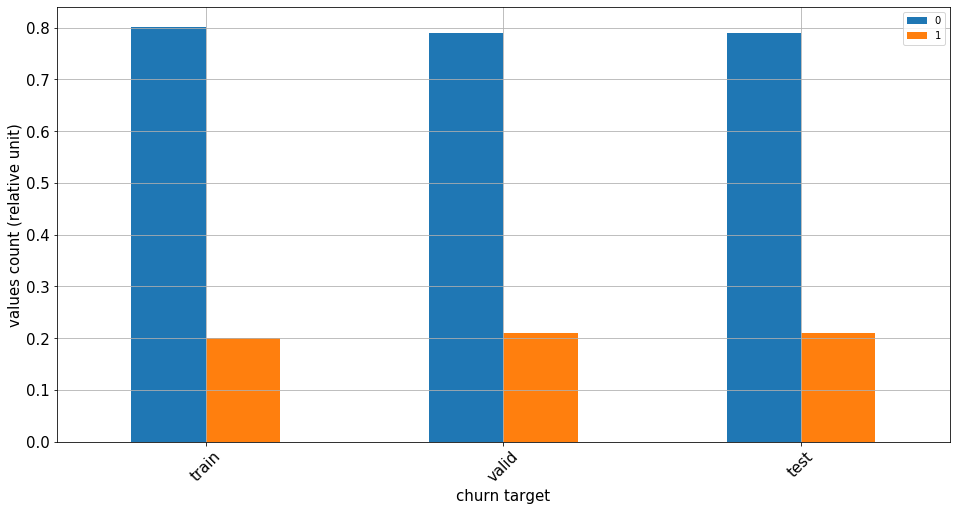

In [28]:
ax = frequencies_data.plot(kind = 'bar', grid = True, rot = 45, figsize = (16, 8), fontsize = 15)
ax.set_xlabel('churn target', fontsize = 15)
ax.set_ylabel('values count (relative unit)', fontsize = 15)

Мы видим явно выраженный дисбаланс классов. Исследуем модели без учета этого дисбаланса.

<a id = '2.2'></a>
Обучим три разные модели буз учета дисбаланса.

In [29]:
dtc_model = DecisionTreeClassifier(random_state = 1)
dtc_model.fit(churn_train_features, churn_train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [30]:
rfc_model = RandomForestClassifier(random_state = 1)
rfc_model.fit(churn_train_features, churn_train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [31]:
lr_model = LogisticRegression(random_state = 1, solver = 'lbfgs')
lr_model.fit(churn_train_features, churn_train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
dtc_predicted_valid = dtc_model.predict(churn_valid_features)
rfc_predicted_valid = rfc_model.predict(churn_valid_features)
lr_predicted_valid = lr_model.predict(churn_valid_features)

<a id = '2.3'></a>
Оценим качество моделей разными метриками.

In [33]:
dtc_accuracy_valid = accuracy_score(churn_valid_target, dtc_predicted_valid)
rfc_accuracy_valid = accuracy_score(churn_valid_target, rfc_predicted_valid)
lr_accuracy_valid = accuracy_score(churn_valid_target, lr_predicted_valid)

In [34]:
print('Accuracy модели DecisionTreeClassifier: {:.4f} \nAccuracy модели RandomForestClassifier: {:.4f} \
      \nAccuracy модели LogisticRegression: {:.4f}'.format(dtc_accuracy_valid, rfc_accuracy_valid, lr_accuracy_valid))

Accuracy модели DecisionTreeClassifier: 0.7880 
Accuracy модели RandomForestClassifier: 0.8515       
Accuracy модели LogisticRegression: 0.7895


Создадим константную модель и сравним её метрику `accuracy` с полученными выше.

In [35]:
target_pred_constant = pd.Series(np.full(shape = (len(churn_valid_target)), fill_value = 0))
print(accuracy_score(churn_valid_target, target_pred_constant))

0.7895


In [36]:
print(classification_report(churn_valid_target, dtc_predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8704    0.8594    0.8649      1579
           1     0.4966    0.5202    0.5081       421

    accuracy                         0.7880      2000
   macro avg     0.6835    0.6898    0.6865      2000
weighted avg     0.7917    0.7880    0.7898      2000



In [37]:
print(classification_report(churn_valid_target, rfc_predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8642    0.9633    0.9111      1579
           1     0.7583    0.4323    0.5507       421

    accuracy                         0.8515      2000
   macro avg     0.8113    0.6978    0.7309      2000
weighted avg     0.8419    0.8515    0.8352      2000



In [38]:
print(classification_report(churn_valid_target, lr_predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.7895    1.0000    0.8824      1579
           1     0.0000    0.0000    0.0000       421

    accuracy                         0.7895      2000
   macro avg     0.3947    0.5000    0.4412      2000
weighted avg     0.6233    0.7895    0.6966      2000



<a id = '2.4'></a>
Построим ROC-кривые для каждой модели, включая случайную.

In [39]:
probabilities_valid_dtc = dtc_model.predict_proba(churn_valid_features)
probabilities_valid_rfc = rfc_model.predict_proba(churn_valid_features)
probabilities_valid_lr = lr_model.predict_proba(churn_valid_features)

In [40]:
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

In [41]:
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(churn_valid_target, probabilities_one_valid_dtc)
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(churn_valid_target, probabilities_one_valid_rfc)
fpr_lr, tpr_lr, threshold_lr = roc_curve(churn_valid_target, probabilities_one_valid_lr)

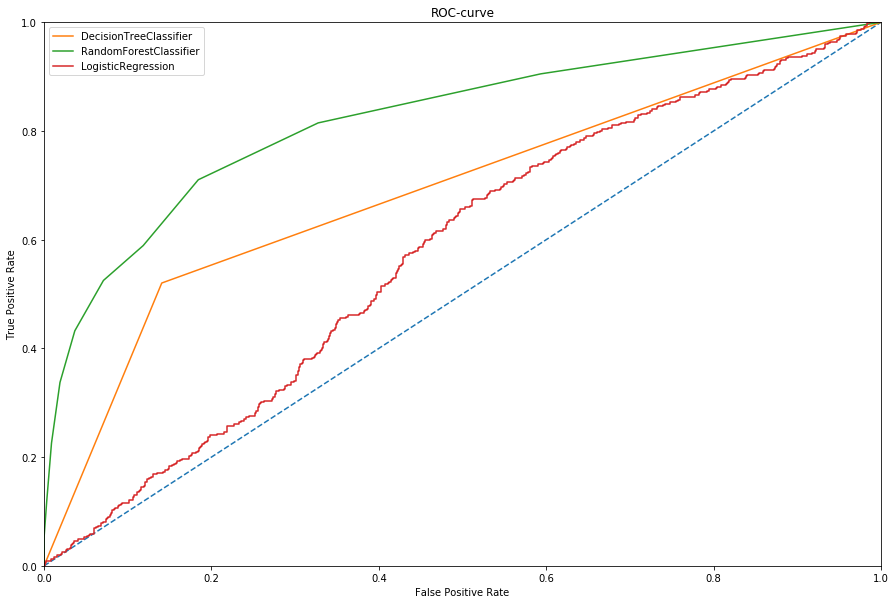

In [42]:
plt.figure(figsize = (15, 10))
plt.plot([0, 1], [0, 1], linestyle = '--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-curve')

plt.plot(fpr_dtc, tpr_dtc, label = 'DecisionTreeClassifier')
plt.plot(fpr_rfc, tpr_rfc, label = 'RandomForestClassifier')
plt.plot(fpr_lr, tpr_lr, label = 'LogisticRegression')
plt.legend()
plt.show()

И рассчитаем AUC-ROC.

In [43]:
auc_roc_dtc = roc_auc_score(churn_valid_target, probabilities_one_valid_dtc)
auc_roc_rfc = roc_auc_score(churn_valid_target, probabilities_one_valid_rfc)
auc_roc_lr = roc_auc_score(churn_valid_target, probabilities_one_valid_lr)

In [44]:
auc_roc_data = pd.DataFrame(data = [roc_auc_score(churn_valid_target, probabilities_one_valid_dtc), \
                                    roc_auc_score(churn_valid_target, probabilities_one_valid_rfc), \
                                    roc_auc_score(churn_valid_target, probabilities_one_valid_lr)], \
                                    index = ['DicisionTreeClassifier','RandomForestClassifier','LogisticRegression'])

Text(0, 0.5, 'AUC-ROC score')

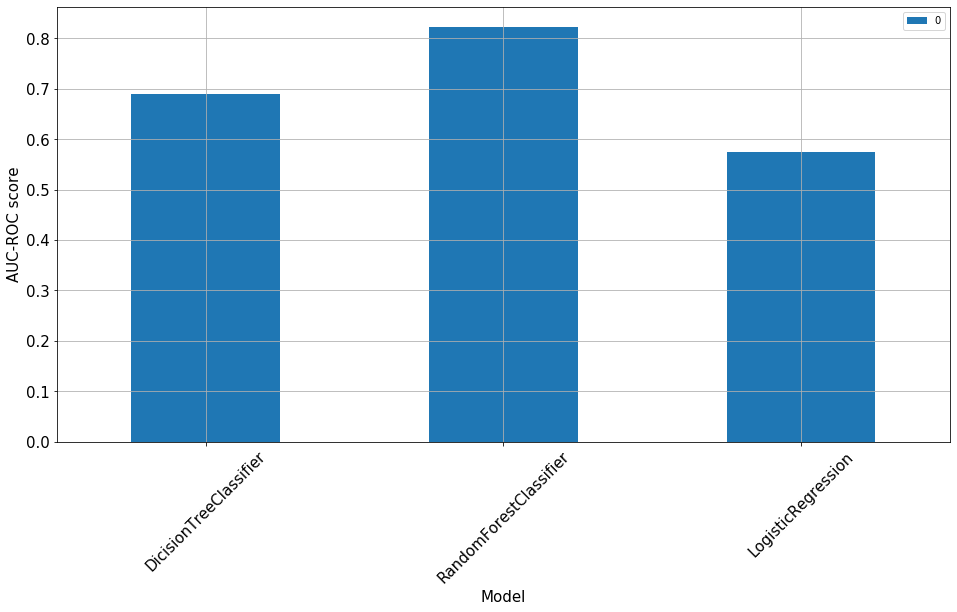

In [45]:
ax = auc_roc_data.plot(kind = 'bar', grid = True, rot = 45, figsize = (16, 8), fontsize = 15)
ax.set_xlabel('Model', fontsize = 15)
ax.set_ylabel('AUC-ROC score', fontsize = 15)

<a id = '2.5'></a>
**Выводы:**   
- мы выявили сильный дисбаланс классов;   
- выявленный дисбаланс, по итогу, плохо сказался на обучении моделей;   
- полнота и точность, конечно, не самые худшие, но все же далеки от единицы. При этом значения полноты, точности и f1-меры для модели LogisticRegression вообще равны нулю, что говорит о том, что класс 1 плохо предсказывается этой моделью;   
- очевидно, что с дисбалансом классов необходимо бороться.

___
[*К содержанию*](#back)

## 3. Борьба с дисбалансом
___

<a id = '3.1'></a>
В первую очередь попробуем использоавть взвешивание классов.

In [46]:
dtc_model = DecisionTreeClassifier(random_state = 1, class_weight = 'balanced')
dtc_model.fit(churn_train_features, churn_train_target)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [47]:
rfc_model = RandomForestClassifier(random_state = 1, class_weight = 'balanced')
rfc_model.fit(churn_train_features, churn_train_target)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

In [48]:
lr_model = LogisticRegression(random_state = 1, solver = 'lbfgs', class_weight = 'balanced')
lr_model.fit(churn_train_features, churn_train_target)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
dtc_predicted_valid = dtc_model.predict(churn_valid_features)
rfc_predicted_valid = rfc_model.predict(churn_valid_features)
lr_predicted_valid = lr_model.predict(churn_valid_features)

In [50]:
print(classification_report(churn_valid_target, dtc_predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8723    0.8695    0.8709      1579
           1     0.5164    0.5226    0.5195       421

    accuracy                         0.7965      2000
   macro avg     0.6944    0.6961    0.6952      2000
weighted avg     0.7974    0.7965    0.7969      2000



In [51]:
print(classification_report(churn_valid_target, rfc_predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8579    0.9639    0.9078      1579
           1     0.7478    0.4014    0.5224       421

    accuracy                         0.8455      2000
   macro avg     0.8029    0.6827    0.7151      2000
weighted avg     0.8348    0.8455    0.8267      2000



In [52]:
print(classification_report(churn_valid_target, lr_predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8504    0.4535    0.5915      1579
           1     0.2547    0.7007    0.3737       421

    accuracy                         0.5055      2000
   macro avg     0.5526    0.5771    0.4826      2000
weighted avg     0.7250    0.5055    0.5456      2000



Метрика f1-score улучшилась, однако до требуемой еще далеко. Но, хотя бы, для модели `LogisticRegression` метрики для класса '1' перестали быть нулевыми.

<a id = '3.2'></a>
Увеличим выборху, применив технику ***'upsampling'***.

In [126]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(churn_train_features, churn_train_target, 10)


In [127]:
dtc_model = DecisionTreeClassifier(random_state = 1)
dtc_model.fit(features_upsampled, target_upsampled)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [128]:
dtc_predicted_valid = dtc_model.predict(churn_valid_features)

In [129]:
rfc_model = RandomForestClassifier(random_state = 1)
rfc_model.fit(features_upsampled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [130]:
rfc_predicted_valid = rfc_model.predict(churn_valid_features)

In [131]:
lr_model = LogisticRegression(random_state = 1, solver = 'lbfgs')
lr_model.fit(features_upsampled, target_upsampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [132]:
lr_predicted_valid = lr_model.predict(churn_valid_features)

In [133]:
print(classification_report(churn_valid_target, dtc_predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8649    0.8797    0.8722      1579
           1     0.5178    0.4846    0.5006       421

    accuracy                         0.7965      2000
   macro avg     0.6913    0.6821    0.6864      2000
weighted avg     0.7918    0.7965    0.7940      2000



In [134]:
print(classification_report(churn_valid_target, rfc_predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8726    0.9322    0.9014      1579
           1     0.6581    0.4893    0.5613       421

    accuracy                         0.8390      2000
   macro avg     0.7654    0.7108    0.7314      2000
weighted avg     0.8274    0.8390    0.8298      2000



In [135]:
print(classification_report(churn_valid_target, lr_predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1579
           1     0.2105    1.0000    0.3478       421

    accuracy                         0.2105      2000
   macro avg     0.1052    0.5000    0.1739      2000
weighted avg     0.0443    0.2105    0.0732      2000



Оп! Выстрелила модель `RandomForestClassifier`. Однако предварительная проверка на тестовой выборке показала метрику f1-score, равную 0.5582, что для нас неудовлетворительно. Теперь реализуем подбор гиперпараметров (ранее этого не делалось, чтобы определить наилучшую модель с гиперпараметрами, принимаемыми по умолчанию). Воспользуемся <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">GridSearchCV</a>. Объявим параметры, которые будем прогонять GridSearch'ем.

In [136]:
forest_parametrs = {
    'n_estimators' : range (5, 51, 5),
    'max_depth' : range (1, 21, 2)
}

In [137]:
#forest_grid = GridSearchCV(rfc_model, forest_parametrs, scoring = 'f1', cv = 5)
#forest_grid.fit(features_upsampled, target_upsampled)

In [138]:
#forest_grid.best_params_

In [139]:
grid_rfc_model = RandomForestClassifier(random_state = 1, max_depth = 17, n_estimators = 50)
grid_rfc_model.fit(features_upsampled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=17, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [140]:
grid_rfc_predicted_valid = grid_rfc_model.predict(churn_valid_features)

In [141]:
print(classification_report(churn_valid_target, grid_rfc_predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.8927    0.9170    0.9047      1579
           1     0.6534    0.5867    0.6183       421

    accuracy                         0.8475      2000
   macro avg     0.7731    0.7519    0.7615      2000
weighted avg     0.8424    0.8475    0.8444      2000



Отлично! Получили неплохую метрику `f1-score`. Забегая вперед отметим что на тестовой выборке `f1-score` равна 0.6060.

<a id = '3.3'></a>
Для сравнения попробуем еще воспользоваться техникой *downsampling* и уменьшим выборку.

In [142]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [143]:
features_downsampled, target_downsampled = downsample(churn_train_features, churn_train_target, 0.40)

In [144]:
grid_down_rfc_model = RandomForestClassifier(random_state = 1, max_depth = 17, n_estimators = 50)
grid_down_rfc_model.fit(features_downsampled, target_downsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=17, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [145]:
grid_down_rfc_predicted_valid = grid_down_rfc_model.predict(churn_valid_features)

In [146]:
print(classification_report(churn_valid_target, grid_down_rfc_predicted_valid, digits = 4))

              precision    recall  f1-score   support

           0     0.9036    0.8847    0.8941      1579
           1     0.5991    0.6461    0.6217       421

    accuracy                         0.8345      2000
   macro avg     0.7514    0.7654    0.7579      2000
weighted avg     0.8395    0.8345    0.8367      2000



___
[*К содержанию*](#back)

<a id = '4'></a>
## 4. Тестирование модели
___

In [147]:
grid_rfc_predicted_test = grid_rfc_model.predict(churn_test_features)

In [148]:
print(classification_report(churn_test_target, grid_rfc_predicted_test, digits = 4))

              precision    recall  f1-score   support

           0     0.8881    0.9291    0.9081      1580
           1     0.6772    0.5595    0.6128       420

    accuracy                         0.8515      2000
   macro avg     0.7827    0.7443    0.7605      2000
weighted avg     0.8438    0.8515    0.8461      2000



In [149]:
grid_down_rfc_predicted_test = grid_down_rfc_model.predict(churn_test_features)

In [150]:
print(classification_report(churn_test_target, grid_down_rfc_predicted_test, digits = 4))

              precision    recall  f1-score   support

           0     0.8999    0.8987    0.8993      1580
           1     0.6209    0.6238    0.6223       420

    accuracy                         0.8410      2000
   macro avg     0.7604    0.7613    0.7608      2000
weighted avg     0.8413    0.8410    0.8411      2000



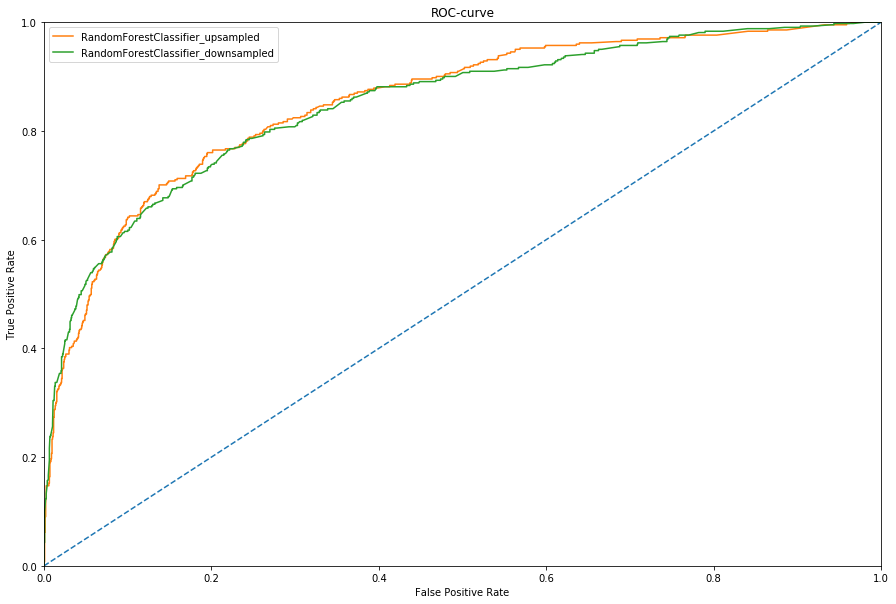

In [151]:
probabilities_valid_grid_rfc_up = grid_rfc_model.predict_proba(churn_valid_features)
probabilities_one_valid_grid_rfc_up = probabilities_valid_grid_rfc_up[:, 1]
fpr_rfc_up, tpr_rfc_up, thresholds_rfc_up = roc_curve(churn_valid_target, probabilities_one_valid_grid_rfc_up)

probabilities_valid_grid_rfc_down = grid_down_rfc_model.predict_proba(churn_valid_features)
probabilities_one_valid_grid_rfc_down = probabilities_valid_grid_rfc_down[:, 1]
fpr_rfc_down, tpr_rfc_down, thresholds_rfc_down = roc_curve(churn_valid_target, probabilities_one_valid_grid_rfc_down)

plt.figure(figsize = (15, 10))
plt.plot([0, 1], [0, 1], linestyle = '--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-curve')

plt.plot(fpr_rfc_up, tpr_rfc_up, label = 'RandomForestClassifier_upsampled')
plt.plot(fpr_rfc_down, tpr_rfc_down, label = 'RandomForestClassifier_downsampled')
plt.legend()
plt.show()

In [152]:
auc_roc_grid_rfc_up = roc_auc_score(churn_valid_target, probabilities_one_valid_grid_rfc_up)
auc_roc_grid_rfc_down = roc_auc_score(churn_valid_target, probabilities_one_valid_grid_rfc_down)
print('AUC-ROC with upsample: {:.4f} \nAUC-ROC with downsample: {:.4f}'.format(auc_roc_grid_rfc_up, auc_roc_grid_rfc_down))

AUC-ROC with upsample: 0.8539 
AUC-ROC with downsample: 0.8487


<a id = '3.4'></a>
### **Выводы**   
Были применены разные техники борьбы с дисбалансом. Лучше всего (почти одинаково по результатам) показали себя `upsample` и `downsample`. При этом были получены разные значения метрики `f1-score`, при разных множителях для увеличения/уменьшения выборки. В коде оставлены наилучшие из рассмотренных: 10 для `upsample` и 0.4 для `downsample`. При этом `f1-score` при использовании техники `downsample` оказалось немного выше, в то время как `AUC-ROC` - ниже. При этом оба значения метрики `AUC-ROC` довольно близки к единице.

___
[*К содержанию*](#back)

<a id = '5'></a>
## 5. Выводы
___

Нам были предоставлены данные о клиентах банка, для исследования и прогнозирования оттока этих клиентов. При обработке данных - часть из них была удалена, как не влияющее на факт ухода клиента из банка. Так же были приведены некоторые типы данных и заполнены пропуски.   
   
Далее был исследован баланс классов и обучена модель без учета выявленного дисбаланса. Исследование модели показало её низкое качество, причиной чего, как раз, и послужил дисбаланс классов.   
   
В связи с этим проводилось улучшение качества моделей за счет масштабирования признаков и выборки в целом. Были применены несколько техник на нескольких видах моделей. В результате были отобраны как лучшие техники, так и лучшая модель.   
   
Что и подтвердилось на финальном тестировании.

___
[*К содержанию*](#back)